# Оценка моделей на основе фигерпринтов Моргана

- Подготовка train, test, подгрузка валидационного сета из in-house данных
- Построение дескрипторов Моргана с радиусом 3, кол-вом bins 2048, их нормализация.
- Построение моделей: LogisticRegressionCV, RandomForestClassifier, XGBRFClassiifier, CatBoost Classifier, SVM (SGDClassifier). А также построение консенсусной модели на основе VotingClassifier.
- Проверка на in-house данных и валидационном сете, оценка данных сетов по similarity c train-сетом.
- Вывод

In [3]:
from pathlib import Path
import sys
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
from sklearn.preprocessing import FunctionTransformer
from pandas import DataFrame
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import zeros
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification 
import xgboost
from xgboost import XGBRFClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
import time
from catboost import CatBoostClassifier, Pool, cv
from collections import Counter, defaultdict
import pickle
import matplotlib.pyplot as plt 

Подгрузим данные ChEMBL, разделим на трэйн и тест.

In [6]:
df = PandasTools.LoadSDF('herg_smaller.sdf',molColName='ROMol')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df, shuffle=True, random_state=75, train_size=.8)

Почистим еще данные: удалим стереоизмеры с разной активностью по полученнным индексам (см 002.0 similarity) и соли

Важно удалить стереоизомеры, у которых разные классы активности из выборки трэйн.
Поскольку модель не должна быть обучена на тех соединениях, где один и один и тот же набор дескрипторов ассоцицирован с разными классами активности.

In [8]:
idx_diff = pd.read_table('s_diff.csv', sep = ",", engine='python')
idx_diff_train = idx_diff['Unnamed: 0'].tolist()

In [9]:
X_train.reset_index(drop=True, inplace=True)

In [10]:
X_train = X_train.drop(idx_diff_train)

In [15]:
def drop_salt(x):
    # удаляет соли из выборки
    x_res = x.drop(x[x.canonical_smiles.str.contains(r'[.]')].index)
    return x_res

In [16]:
X_train = drop_salt(X_train)

In [17]:
X_test = drop_salt(X_test)

In [21]:
def to_one_class(x, name, types):
    # приводит соединения к одному классу, поскольку формат csv/sdf не сохраняет класс объекта.
    x_res = x[name].astype({name: types})
    return x_res

In [22]:
X_train["class"] = to_one_class(X_train, name = 'class', types = int)

In [23]:
X_test["class"] = to_one_class(X_test, name = 'class', types = int)

Подгрузим in-house данные

In [25]:
df_in_house = pd.read_csv('17_candidates.csv', sep = ",", engine='python')


Удалим соединения-стандарты, которые используются при оценке herg-токсичности, поскольку они все присутствуют в выборке трэйн, а также относятся к разным классам с in-house данными.

In [26]:
df_sh = df_in_house.iloc[4: , :]
df_sh.reset_index(drop=True, inplace=True)
df_sh

,Smiles,no,IC50_nM,class
0,CN1CCN(C2=CC(=CC(=C2)S(=O)(=O)C)NC2=NN3C(C4=CC...,26,3240,1
1,CN(CCN(C1C=CC(C2=CC3=C(N2)N=CC=C3NC2=C(P(=O)(C...,48,30000,0
2,CN1CCN(C2=CC(S(=O)(=O)C)=CC(=C2)NC2=NN3C(C4=CC...,336,2116,1
3,CN1CCN(C2CC(NC3=NN4C(C5=CC6=C(C=C5)NN=C6)=CC=C...,341,30000,0
4,CN1CCN(C2=CC(=CC(=C2)S(=O)(=O)C)NC2=NN3C(C4=CC...,410,7577,1
5,CN(CCN1C2=C(C=C(C3N4C(=NC(=N4)NC4=CC(N5CCN(CC5...,415,7111,1
6,CN1CCN(C2=CC(S(=O)(=O)C)=CC(=C2)NC2=NN3C(C4=CC...,417,1966,1
7,CN1CCN(C2=CC(=CC(=C2)NC2=NN3C(C4=CC5=C(C=C4)NN...,422,2616,1
8,CCCN1CCN(C2C=C(S(=O)(=O)C)C=C(C=2)NC2=NN3C(C4=...,429,2811,1
9,CN(CCN1C2=C(C=C(C3N4C(=NC(=N4)NC4=CC(S(=O)(=O)...,432,10252,0


In [27]:
def standardize_smiles(df, col_smiles):
    logs = 0
    mols = []
    for i in df[col_smiles]:    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(f"Errors: {logs}")
    df["ROMol"] = mols
    return df

Errors: 0
Errors: 0


<ipython-input-27-25d8bc2fafea>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ROMol"] = mols


,Smiles,no,IC50_nM,class,ROMol
0,c1cc(F)ccc1Cn2c(nc(c23)cccc3)NC4CCN(CC4)CCc5cc...,Astemizole,2,1,
1,c1ccc(nc1C)CCN2CCC(CC2)C(=O)c3ccc(cc3)NS(=O)(=O)C,E-4031,35,1,
2,CS(=O)(=O)Nc1ccc(cc1)CCN(C)CCOc2ccc(cc2)NS(=O)...,Dofetilide,11,1,
3,c1cc(F)ccc1C(c2ccc(F)cc2)CCCN3CCC(CC3)n4c(=O)[...,Pimozide,3,1,
4,CN1CCN(C2=CC(=CC(=C2)S(=O)(=O)C)NC2=NN3C(C4=CC...,26,3240,1,
5,CN(CCN(C1C=CC(C2=CC3=C(N2)N=CC=C3NC2=C(P(=O)(C...,48,30000,0,
6,CN1CCN(C2=CC(S(=O)(=O)C)=CC(=C2)NC2=NN3C(C4=CC...,336,2116,1,
7,CN1CCN(C2CC(NC3=NN4C(C5=CC6=C(C=C5)NN=C6)=CC=C...,341,30000,0,
8,CN1CCN(C2=CC(=CC(=C2)S(=O)(=O)C)NC2=NN3C(C4=CC...,410,7577,1,
9,CN(CCN1C2=C(C=C(C3N4C(=NC(=N4)NC4=CC(N5CCN(CC5...,415,7111,1,

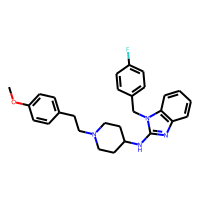
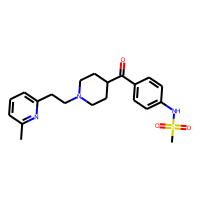
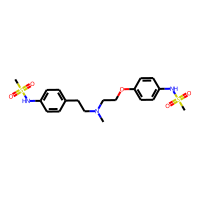
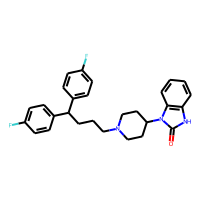
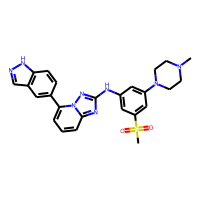
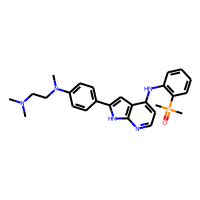
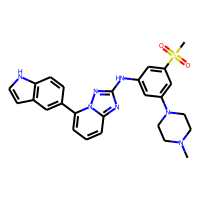
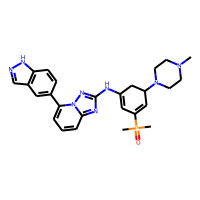
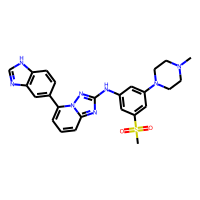
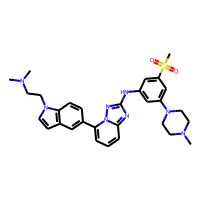
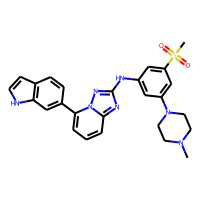
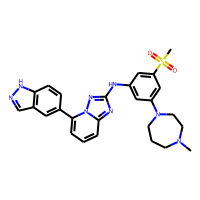
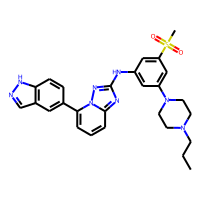
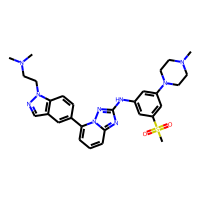
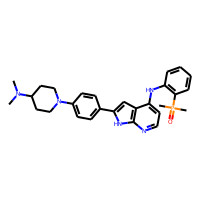
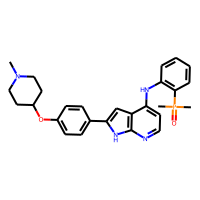
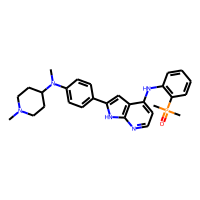

In [28]:
df_in_house = standardize_smiles(df_in_house, "Smiles")
df_sh = standardize_smiles(df_sh, "Smiles")
df_in_house

Построение дескрипторов - молекулярные отпечатки по методу Моргана

In [29]:
def calc_morgan(mols):
    """ генерация молекулярных отпечатков по методу Моргана с радиусом 3
    """
    for_df = []
    for m in mols:
        arr = zeros((1,), dtype=int)
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(m, 3, 2048), arr)
        for_df.append(arr)
    return DataFrame(for_df)

In [30]:
morgan_transformer = FunctionTransformer(calc_morgan, validate=False)
X_train_fp = morgan_transformer.transform(X_train["ROMol"])
X_test_fp = morgan_transformer.transform(X_test["ROMol"])
df_in_house_fp = morgan_transformer.transform(df_in_house["ROMol"])
df_sh_fp = morgan_transformer.transform(df_sh["ROMol"])

In [31]:
def stscaler(X):
    #нормализация
    scaler = StandardScaler()
    scaler.fit(X.values)
    X = DataFrame(scaler.transform(X.values), index=X.index, columns=X.columns)
    return X

In [32]:
X_norm_train = stscaler(X_train_fp)
X_norm_test = stscaler(X_test_fp)
df_norm = stscaler(df_in_house_fp)
df_sh_norm = stscaler(df_sh_fp)

Построение моделей

Логистическая регрессия CV (параметр С подбирается автоматически)

In [33]:
cv = RepeatedStratifiedKFold(n_splits=5, random_state=1, n_repeats=3)

In [34]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)

В случае логистической регрессии пришлось установить max_iter = 20000, с соответствующим увеличением времени обучния.
Иначе модель не может полностью обучиться, о чем выдается WARNING (недостаточно итераций)

In [43]:
clf = LogisticRegressionCV(cv = kf, max_iter = 20000).fit(X_norm_train, X_train["class"])

In [36]:
filename = 'LR_MFP_3.py'

In [39]:
import pickle
pickle.dump(clf, open(filename, 'wb'))

In [40]:
loaded_model = pickle.load(open(filename, 'rb'))

In [41]:
def print_metrics(y_test, X_test, clf):
    # считает все целевые метрики
    y_testf1 = np.transpose((np.array(y_test)).astype(np.int32))
    zt = list((clf.predict(X_test)).astype(np.int32))
    print(f"roc auc test_set = {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}")
    print(f"bac test_set = {balanced_accuracy_score(y_test, clf.predict(X_test))}")
    print(f"acc test_set = {accuracy_score(y_test, clf.predict(X_test))}")
    print(f"f1_score ={f1_score(y_testf1, zt)}")
    print(f"recall_score ={recall_score(y_testf1, zt)}")
    print(f"precision_score ={precision_score(y_testf1, zt)}")

In [42]:
res = print_metrics(X_test["class"], X_norm_test, clf)

NotFittedError: This LogisticRegressionCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

RandomForestClassifier c кросс-валидацией. n-estimators, criterion были определены через gs (grid search) ранее.

In [53]:
cv = RepeatedStratifiedKFold(n_splits=5, random_state=1, n_repeats=3)

In [54]:
model = RandomForestClassifier(random_state=42, n_estimators = 1000,  criterion = 'entropy')

In [57]:
df_norm = pd.concat([X_norm_train, X_norm_test])

In [60]:
y = pd.concat([X_train["class"], X_test["class"]])

In [62]:
n_scores = cross_val_score(model, df_norm, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [63]:
print('Mean roc_auc: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean roc_auc: 0.841 (0.009)


Без кросс-валидации, на тесте:

In [64]:
model1 = RandomForestClassifier(random_state=42, n_estimators = 1000,  criterion = 'entropy').fit(X_norm_train, X_train["class"])

In [77]:
filename = 'RF_MFP_3.py'

In [78]:
import pickle
pickle.dump(model1, open(filename, 'wb'))

In [79]:
loaded_model = pickle.load(open(filename, 'rb'))

In [80]:
res = print_metrics(X_test["class"], X_norm_test, loaded_model)

roc auc test_set = 0.8511106303769799
bac test_set = 0.7756734896831405
acc test_set = 0.7779187817258884
f1_score =0.7576177285318559
recall_score =0.7303070761014686
precision_score =0.7870503597122303


In [144]:
# gs = GridSearchCV(RandomForestClassifier(random_state=42, n_estimators = 100, criterion = 'entropy'), {'max_features': ("auto", 'log2', None)})

In [145]:
# gs.fit(X_norm_train, X_train["class"])

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'max_features': ('auto', 'log2', None)})

In [146]:
# gs.best_params_

{'max_features': 'auto'}

XGBoost

- n_estimators=1000 - number of estimators
- subsample=0.8 - percent of rows in the train
- colsample_bynode = sqrt(2048) / 2048 is the square root of the number of features/features

Без кросс-валидации, на тесте:

In [67]:
clf = XGBRFClassifier(n_estimators=1000, subsample=0.8, colsample_bynode=0.02).fit(X_norm_train, X_train["class"])

/Users/elly/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [71]:
filename = 'XGBRF_MFP_3.py'

In [72]:
import pickle
pickle.dump(clf, open(filename, 'wb'))

In [73]:
loaded_model = pickle.load(open(filename, 'rb'))

In [74]:
res = print_metrics(X_test["class"], X_norm_test, loaded_model)

roc auc test_set = 0.7294135025660979
bac test_set = 0.6404371487658675
acc test_set = 0.6516497461928934
f1_score =0.5303678357570574
recall_score =0.41388518024032045
precision_score =0.7380952380952381


In [69]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [ ]:
n_scores = cross_val_score(loaded_model, X_norm_train, X_train["class"], scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
print('Mean roc_auc: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Cat Boost Classifier

In [88]:
# !jupyter nbextension enable --py widgetsnbextension

In [62]:
model = CatBoostClassifier(learning_rate=0.1,
                           loss_function='Logloss', verbose = False).fit(X_norm_train, X_train["class"], plot = True)
                           

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
filename = 'CatBoost_MFP_3.py'
pickle.dump(model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

In [69]:
res = print_metrics(X_test["class"], X_norm_test, loaded_model)

roc auc test_set = 0.8477268361039224
bac test_set = 0.7662267949365781
acc test_set = 0.7684010152284264
f1_score =0.7477539737387697
recall_score =0.7222963951935915
precision_score =0.7750716332378224


Отрисуем процесс обучения:

In [70]:
feature_names = [f'feature {i}' for i in X_norm_test.columns]
booster = CatBoostClassifier(verbose = False)
booster.fit(X_norm_train, X_train["class"], eval_set =(X_norm_test, X_test["class"]), plot=True);
booster.set_feature_names(feature_names)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

SVM - Support Vector Machine

In [139]:
clf4 = SGDClassifier(loss ="log",alpha=.1, random_state=42).fit(X_norm_train, X_train["class"])

In [141]:
filename = 'SGD_MFP_3.py'
pickle.dump(clf4, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

In [143]:
res = print_metrics(X_test["class"], X_norm_test, loaded_model)

roc auc test_set = 0.7958527532881408
bac test_set = 0.7166629266268769
acc test_set = 0.7176395939086294
f1_score =0.7011417058428476
recall_score =0.6969292389853138
precision_score =0.7054054054054054


In [19]:
clf1 = RandomForestClassifier(random_state=42, n_estimators = 1000, criterion = 'entropy')
clf2 = CatBoostClassifier(learning_rate=0.1, loss_function='Logloss', verbose = False)

In [20]:
eclf = VotingClassifier(estimators=[('RF1', clf1), ('CatBoost', clf2)], voting ='soft', weights=[1, 1])

In [21]:
eclf = eclf.fit(X_norm_train, X_train["class"])

In [24]:
def print_metrics(y_test, X_test, clf):
    y_testf1 = np.transpose((np.array(y_test)).astype(np.int64))
    zt = clf.predict(X_test).astype(np.int64)
    print(f"roc auc test_set = {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}")
    print(f"bac test_set = {balanced_accuracy_score(y_test, clf.predict(X_test))}")
    print(f"acc test_set = {accuracy_score(y_test, clf.predict(X_test))}")
    print(f"f1_score ={f1_score(y_testf1, zt)}")
    print(f"recall_score ={recall_score(y_testf1, zt)}")
    print(f"precision_score ={precision_score(y_testf1, zt)}")

In [25]:
res = print_metrics(X_test["class"], X_norm_test, eclf)

roc auc test_set = 0.8548076193489746
bac test_set = 0.7738597049189326
acc test_set = 0.7760152284263959
f1_score =0.756046993780235
recall_score =0.7303070761014686
precision_score =0.7836676217765043


Теперь проверим in-house данные.

In [241]:
res = print_metrics(df_sh["class"], df_sh_norm, eclf)

roc auc test_set = 0.2619047619047619
bac test_set = 0.5
acc test_set = 0.46153846153846156
f1_score =0.0
recall_score =0.0


/Users/elly/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_score =0.0


In [26]:
y_test = X_test["class"].astype("int64")
y_test1 = df_in_house["class"].astype("int64")
probs = eclf.predict_proba(X_norm_test)
probs1 = eclf.predict_proba(df_norm)
preds = probs[:,1]
preds1 = probs1[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label = 1)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test1, preds1, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc1 = metrics.auc(fpr1, tpr1)

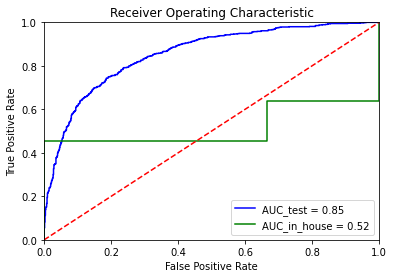

In [27]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_test = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'g', label = 'AUC_in_house = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
proba_test = eclf.predict_proba(X_norm_test)
preds_test = []
for list in proba_test:
    preds_test.append(int(list[1] >= 0.2))
    print(int(list[1] >= 0.2))

1
0
0
0
1
1
1
1
0
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
1
0
0
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
0
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
0
1
1
0
0
1
0
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
0
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
0
1
1
0
1
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
1
0
1
0
1
1
1
1
1
0
1
0
1
1
1
1
0
0
0
0
0
1
1
0
1
1
0
1
1
0
1
0
1
0
1
1
1
0
0
0
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
1
0
1
1
0
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
0
1
1
1
0
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
0
0
0
1
1
1
0
0
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
0
1
0
1
1
1
0
1
0
1
1
1
1
1
0
1
0
1
0
1
1
0
0
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
0
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
0
0
0
1
1
0
1
1
1
0
1
1
0
0
1
1
1
0
0
0
0
1
0
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
0
1
0
1
0
0
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
0
1
1
0
0
0
1
1
0
0
1
1
0
1
1
1
0
1
0
1
1
1
1
0
1
1
1
1
0
0
0
1


In [29]:
X_test["class"]

3946    1
5765    0
5492    0
7379    0
6849    0
       ..
7564    1
7764    0
105     0
4056    1
3265    1
Name: class, Length: 1576, dtype: int64

In [30]:
tn, fp, fn, tp = confusion_matrix(X_test["class"], preds_test).ravel()
print(tn, fp, fn, tp)

370 457 43 706


In [32]:
target_names = ["class nonblockers", "class blockers"]
print(classification_report(X_test["class"], eclf.predict(X_norm_test), target_names=target_names))

                   precision    recall  f1-score   support

class nonblockers       0.77      0.82      0.79       827
   class blockers       0.78      0.73      0.76       749

         accuracy                           0.78      1576
        macro avg       0.78      0.77      0.77      1576
     weighted avg       0.78      0.78      0.78      1576



In [33]:
target_names = ["class nonblockers", "class blockers"]
print(classification_report(X_test["class"], preds_test, target_names=target_names))

                   precision    recall  f1-score   support

class nonblockers       0.90      0.45      0.60       827
   class blockers       0.61      0.94      0.74       749

         accuracy                           0.68      1576
        macro avg       0.75      0.69      0.67      1576
     weighted avg       0.76      0.68      0.66      1576



In [98]:
proba = eclf.predict_proba(df_norm)
preds = []
for list in proba:
    preds.append(int(list[1] < 0.2))
    print(int(list[1] < 0.2))

1
0
1
1
0
0
1
1
0
0
0
0
0


In [99]:
df_in_house["class"]

4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
14    0
15    0
16    0
Name: class, dtype: int64

In [102]:
tn, fp, fn, tp = confusion_matrix(df_in_house["class"], preds).ravel()
print(tn, fp, fn, tp)

5 1 3 4


Процент верно определенных соединений:

In [105]:
print(f'Procent_of_right_answers: {((tn+tp)/(tn+fp+fn+tp))*100} %')

Procent_of_right_answers: 69.23076923076923 %


Посмтрим Танимото-матрицу in-house данных с трэйном, чтобы выяснить насколько были похожи датасеты.

In [124]:
df_sh = df_in_house.iloc[ 4:17 , : ]

In [229]:
def calculate_tanimoto_matrix(df_in, df2):
    # Для каждого значения из теста расчитает индекс Танимото с каждым соединением из трэйна. Получим матрицу.
    mols_train = df_in["ROMol"].tolist()
    mols_test = df2["ROMol"].tolist()
    fp_mg2_bin = [AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mols_train]
    fp_mg2_bin_test = [AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mols_test]
    df = pd.DataFrame(index=range(1),columns=range(len(df_in)))
    for idx in range(len(fp_mg2_bin_test)):
        tanimoto_mg2_bin = DataStructs.BulkTanimotoSimilarity(fp_mg2_bin_test[idx], [fp for i, fp in enumerate(fp_mg2_bin)])
        df_length = len(df)
        df.loc[df_length] = tanimoto_mg2_bin
    df = df.iloc[1: , :]
    return(df, mols_test, mols_train, fp_mg2_bin, fp_mg2_bin_test)

In [230]:
df1, mols_test, mols_train, fp_mg2_bin, fp_mg2_bin_test = calculate_tanimoto_matrix(df_sh, df)

In [231]:
df_sort = df1.max(axis = 1)
df_sort = df_sort.sort_values(ascending=False)
df_sort

3026    0.276923
4162    0.268657
3028    0.265625
1845    0.257143
3024    0.253731
          ...   
7382    0.051282
7525    0.049296
7623    0.048387
23      0.046875
5077    0.045455
Length: 8158, dtype: float64

In [232]:
def count_tanimoto_range_3(df1, dot1, dot2):
    # данная функция расчитывает диапазон по индексу Танимото, куда попали пары соедиений. Диапазон из 3 частей.
    count_ = Counter()
    for i in df1:
        if i <= dot1:
            count_[f"Tanimoto_index = 0.00 - {dot1}"]+=1
        elif i <= dot2 and i > dot1:
            count_[f"Tanimoto_index = {dot1} - {dot2}"]+=1
        elif i >  dot2:
            count_[f"Tanimoto_index = {dot2} - 1.00"]+=1
    return count_

In [233]:
count_ = count_tanimoto_range_3(df_sort, 0.33, 0.66)
print(count_)

Counter({'Tanimoto_index = 0.00 - 0.33': 8158})


Все соединения in-house данных при сравнении с train-сетом лежат в диапазоне 0-0.33. Это означает, что данная модель не может хорошо предсказывать данные соединения. Данных ChEMBL не хватает для построения модели, которая могла бы эффективно работать c данными in-house.

Посмотрим на то, как будет предсказан лист соединений in_house + соединения-стандарты

In [243]:
res = print_metrics(df_in_house["class"], df_norm, eclf)

roc auc test_set = 0.5151515151515151
bac test_set = 0.6818181818181819
acc test_set = 0.5882352941176471
f1_score =0.5333333333333333
recall_score =0.36363636363636365
precision_score =1.0


In [244]:
y_test = X_test["class"].astype("int64")
y_test1 = df_sh["class"].astype("int64")
y_test2 = df_in_house["class"].astype("int64")
probs = eclf.predict_proba(X_norm_test)
probs1 = eclf.predict_proba(df_sh_norm)
probs2 = eclf.predict_proba(df_norm)
preds = probs[:,1]
preds1 = probs1[:,1]
preds2 = probs2[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label = 1)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test1, preds1, pos_label = 1)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test2, preds2, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)

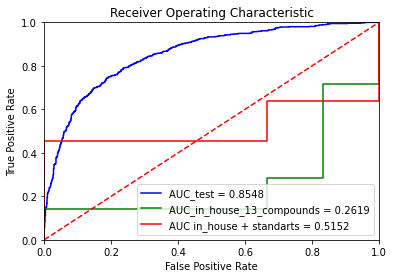

In [249]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC_test = {roc_auc.round(4)}')
plt.plot(fpr1, tpr1, 'g', label = f'AUC_in_house_13_compounds = {roc_auc1.round(4)}')
plt.plot(fpr2, tpr2, 'r', label = f'AUC in_house + standarts = {roc_auc2.round(4)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [252]:
df_sh_norm

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0
1,0.0,0.0,0.0,-1.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.500000,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0
2,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,3.464102,0.0
3,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0
4,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0
5,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0
6,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0
7,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0
8,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0
9,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.666667,0.0,0.0,0.0,-0.426401,0.0,0.0,-0.288675,0.0


In [250]:
df_norm

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,-0.25,0.0,-1.060660,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,-0.365148,0.0
1,0.0,-0.25,0.0,-1.060660,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,-0.365148,0.0
2,0.0,-0.25,0.0,-1.060660,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,-0.365148,0.0
3,0.0,4.00,0.0,-1.060660,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,2.738613,0.0
4,0.0,-0.25,0.0,0.942809,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,-0.365148,0.0
5,0.0,-0.25,0.0,-1.060660,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.802776,0.0,0.0,0.0,-0.365148,0.0,0.0,-0.365148,0.0
6,0.0,-0.25,0.0,0.942809,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,2.738613,0.0
7,0.0,-0.25,0.0,0.942809,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,-0.365148,0.0
8,0.0,-0.25,0.0,0.942809,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,-0.365148,0.0
9,0.0,-0.25,0.0,0.942809,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.554700,0.0,0.0,0.0,-0.365148,0.0,0.0,-0.365148,0.0


Во-первых, как видно, проблемы возникают при стандартизации. Вероятно, необходимо стандартизовать все соединения и предсказываемый датасет до построения модели. А затем нормализованные данные разбивать на трэйн, тест, in-house. Но в таком случае алгоритм заметно усложняется. Т.е. пользователю надо вначале суммировать свою молекулу с ChEMBL-данными, нормализовать в одном котле, и уже затем построить на этом трэйне модель и только потом предсказать. Модель в виде бинарных данных тогда сохранить не получится...

Выводы
- Tanimoto-matrix: все соединения in-house данных при сравнении с train-сетом лежат в диапазоне 0-0.33. Это означает, что данная модель не может хорошо предсказывать данные соединения. Данных ChEMBL не хватает для построения модели, которая могла бы эффективно работать c данными in-house.
- Возникают проблемы при нормализации данных, в случае комбинирования в одном сете сильно различных классов (in_house соединений + стандартов, на которых делают тест in vitro по кардиотоксичности).   